<a href="https://colab.research.google.com/github/gabmardakhaev/NLE/blob/main/NLE_MovieClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLE Assignment: Sentiment Classification




In [1]:
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [2]:
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [3]:
random.seed(300000)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['it', 'might', 'surprise', 'some', 'to', 'know', ...], 'pos')


In [4]:
#Create a set of stopwords
stop = stopwords.words('english')

#Function to normalise wordlist
def normalise(wordlist):
    #Puts everyword into lowercase incase its already not
    lowered=[word.lower() for word in wordlist]
    #Gets rid of the stop words and punction
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

#Storing the normalised lists in variables
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

#Create FreqDist
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()


#Loop through the training normalised list
for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

#Store the difference between
posdiff=pos_freq_dist-neg_freq_dist

#Function to find the most frequent words
def most_frequent_words(posfreq,negfreq,topk):
    #Remove the negative words from the positive words
    difference=posfreq-negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

#Top positive words
top_pos=most_frequent_words(pos_freq_dist,neg_freq_dist,10)
print("This is a list which represents the positive reviews in the training data:\n{}".format(top_pos))

#Top negative words
top_neg=most_frequent_words(neg_freq_dist,pos_freq_dist,10)
print("\nThis is a list which represents the negative reviews in the training data:\n{}".format(top_neg))

This is a list which represents the positive reviews in the training data:
['film', 'life', 'also', 'great', 'world', 'best', 'well', 'story', 'many', 'love']

This is a list which represents the negative reviews in the training data:
['movie', 'bad', 'plot', 'even', 'nothing', 'worst', 'get', 'script', 'stupid', 'least']


Firstly I created a set of stopwords using the NLTK corpus 'stopwords'. \

After that I defined a function called 'normalise' that takes a list of words and converts each word to lowercase, then filters out non-alphabetic words and stopwords. \

Then I applied normalisation function to the training and testing data, where I represented the review as a pair of FreqDist and a label.

Then I created a FreqDist for positive and negative reviews based on the normalised training data. \

Now I must find the top positive and top negative words and in order to do so I defined a function called 'most_frequent_words'. It takes two FreqDist and returns top words.

Finally I must print out the top positive and negative words.


In [5]:
#Define a class SimpleClassifier that inherits the class ClassifierI
class SimpleClassifier(ClassifierI):

    #It takes two parameters in the constructor
    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    #Define a function to classify the document
    def classify(self, doc):
        #Initialize a score variable to zero
        score = 0

        #Iterate through each word in the FreqDist
        for word,value in doc.items():
            #If the word is positive add the frequency value to score
            if word in self._pos:
                score+=value
            #If the word is negative subtract the frequency value to score
            if word in self._neg:
                score-=value
        #Returns 'neg' if the score is less than 0 and 'pos' otherwise
        return "neg" if score < 0 else "pos"

    #Define a function that returns positive or negative labels
    def labels(self):
        return ("pos", "neg")

#Create an instance of the class using the lists top_pos and top_neg
classifier = SimpleClassifier(top_pos,top_neg)
#Example
classifier.classify(FreqDist("This was bad".split()))




'neg'

In [6]:
#Define a class SimpleClassifier_mf that inherits the class SimpleClassifier
class SimpleClassifier_mf(SimpleClassifier):

    #Constructor
    def __init__(self,k):
        self._k=k

    #Define a function that adapts the classifier based on the training data
    def train(self,training_data):

        #Positive and negative FreqDist
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        #Labels are updated in the training data
        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist

        #Most frequent words
        self._pos=most_frequent_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=most_frequent_words(neg_freq_dist,pos_freq_dist,self._k)

Firstly, I defined a class called 'SimpleClassifier' that inherits the NLTK 'ClassifierI' class. The purpose of this of classifier is to classify documents into positive or negative. The constructor takes two parameters 'pos' and 'neg' which are going to be the lists of top positive and negative words.

Then I defined a function called classify that takes a 'doc' as a parameter which is going to be the FreqDist that we need to classify. In the method it first set the score equal to zero, then it iterates through each word in the document and adds the frequency value the to the score if the word is positive or subtracts the frequency value from the score if its negaative. The function then returns either 'pos' or 'neg.

Also I defined a function 'labels' that simply returns a label either 'pos' or 'neg'.

Finally, I created an instance of the 'SimpleClassifier' with 'top_pos' and 'top_neg' as the top positive and negative word lists. Then I created an example to test the code and used the string "This was bad" and it returned me 'neg' as the comment was negative.

In addition to this, I created a subclass called 'SimpleClassifier_mf' that is not necessarily needed to answer question 2 but is needed to answer future questions. In short this class inherits the 'SimpleClassifier' class and it extends its functionality of the 'SimpleClassifier' by adding a training method that updates the classifier's positive and negative wordlists based on a new training data set.


In [7]:
from nltk.tag.api import accuracy
#Function to evaluate the classifier's accuracy
def classifier_evaluate(cls, test_data):
    acc = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    #calculate and return accuracy
    return acc / (len(test_data))

#Class to compute confusion matrix
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes
        #self.predictions=predictions
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0

        #Populate the values based on predictions and gold standard
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1

    #Compute precision
    def precision(self):
        p=0
        p = self.TP / (self.TP + self.FP)
        return p

    #Compute recall
    def recall(self):
        r=0
        r = self.TP / (self.TP + self.FN)
        return r

    #Compute F1 score
    def f1(self):
        f1=0
        p=self.precision()
        r=self.recall()
        f1=(2 * p * r)/(p+r)
        return f1

#Evaluate classifier on the testing dataset
score = classifier_evaluate(classifier, testing_norm)

docs,labels=zip(*testing_norm)

#Create a confusion matrix using classifier predictions and gold standard labels
confusionMatrix = ConfusionMatrix(classifier.classify_many(docs),labels)

#Calculate precision, recall, and F1 score
precision = confusionMatrix.precision()
recall = confusionMatrix.recall()
f1_score = confusionMatrix.f1()

#Print the results
print("Accuracy: ",score)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1_score)

Accuracy:  0.64
Precision:  0.5990566037735849
Recall:  0.8466666666666667
F1:  0.701657458563536


Evaluating a classifier solely based on accuracy may not always be reasonable, and it depends on the characteristics of the problem and the dataset. Accuracy is the ratio of correctly predicted instances to the total instances, and while it is a commonly used metric, it might not provide a complete picture of a classifier's performance, especially in imbalanced datasets.

It would be reasonable to evaluate the accuracy in scenarios where the classes are balanced, meaning there is approximately equal number of instances for each class. In such cases accuracy can provide a clear measure of overall performance.

However, it would not be reasonable to evaluate the accuracy in datasets where one class outnumbers the other. This is because, it can achieve a high accuracy on the majority class that performs well even if the minority class performs poorly.

An example of this is suppose we need to identify a rare disease and we are given dataset that consists of 99% healthy patients and 1% with the disease. In this case the accuracy is going to be 99% and would notice patients that have the disease. For this we use different evaluation metrics such as precision and recall as well as the F1 score which is the mean of precision and recall.

In [8]:
from nltk.classify.api import ClassifierI
import math

#Naive Bayes classifier
class NBClassifier(ClassifierI):

    def __init__(self):
        pass

    #Function to set the known vocabulary based on training data
    def _set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)

    #Function to set class priors based on training data
    def _set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors

    #Function to set conditional probabilities based on training data
    def _set_cond_probs(self,training_data):
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1

            conds[label]=classcond

        for label, classcond in conds.items():
            for word in self.known:

                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond

        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}

        self.conds=conds

    #Main trainig function
    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)

    #Classify a single document
    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

#Instance of the Naive Bayes Classifier
nbClassifier = NBClassifier()
#Train the classifier on the normalised training data
nbClassifier.train(training_norm)
#Classify multiple documents using the trained classifier
nbClassifier.classify_many(doc for (doc,label) in testing_norm)




['pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',


In [9]:
#Evaluate the Naive Bayes classifier on the testing data set
score1 = classifier_evaluate(nbClassifier, testing_norm)
#Unpack the testing data into seperate lists of documents and labels
test, label = zip(*testing_norm)
#Create a confusion matrix based on the Naive Bayes classifier predictions and gold standard labels
confusionMatrix2 = ConfusionMatrix(nbClassifier.classify_many(test),label)
#Calculate the metrics
precision1 = confusionMatrix2.precision()
recall1 = confusionMatrix2.recall()
f1_score1 = confusionMatrix2.f1()

#Print the results
print("Accuracy: ", score1)
print("Precision: ",precision1)
print("Recall: ",recall1)
print("F1: ",f1_score1)


Accuracy:  0.8266666666666667
Precision:  0.8181818181818182
Recall:  0.84
F1:  0.8289473684210527


The Naive Bayes classifier's performance is far better in each metric, suggesting it is more effective at handling complexity of classification task, than the word list classifier.

Even though the word list classifier achieved a good score and recall the precision is quite a low there fore the F1 score is lower than in the Naive bayes classifier, which indicates a higher rate in false positives

In conclusion, the Naive Bayes classifier is demonstrates a better performance, this improvemnent is likely due to the Naive Bayes classifier's ability to capture more subtle patterns in the data.

In the code bellow I started by creating a new dictionary called 'classifiers', which contains the name of the classifier as a key and an instance of the 'SimpleClassifier_mf' class with a specified parameter of 100.

After that I initialised program parameters: 'number_of_runs' and 'sample_sizes', which is the number of times the experiment is repeated for each sample size and the different number of sample sizes.

To make the experiment simpler I created dictionaries for each of the results (accuracy, precision, recall and F1 score), which stores the average metric for each sample size.

Then I created nested loops, where the outer loop iterates over different sample sizes and the inner loop repeats the experiment the desired number of time which specified in the 'number_of_runs' variable.

For each run there is new training and testing data created using the 'get_train_test_data', so we can get store the new instances and run the function on them. I seperated the positive and negative instances based on their labels and I also created a balanced training sample of both positive and negative randomly selected instances.

Using the training sample I trained the classifier 'SimpleClassifier_mf' and then I could calculate the accuracy, precision, recall and F1 score using the 'classifier_evaluate' function and 'ConfusionMatrix' class

Then the average results over the number of runs for each metric is updated and stored in the dictionary accordingly. Then we finally print the results.

Lastly, in order to make the experiment easy-to-read and understandable I created a table and a graph for each metric.

Following the graphs we find that increasing the sample size will also mean that Confusion Matrix metrics and accuracy increase accordingly.

In the results we could see that even the highest accuracy, precision, recall and F1 score of the 'SimpleClassifier_mf' class the results of the Naive Bayes is still higher.

In conclusion, this experiment is done to see how the performance of the "Word List MF" classifier is varies with different sample sizes. This helps us to understand the robustness and scalability of the classifier over different amounts of training data.



In [10]:
from random import sample

#Dictionary of classifiers
classifiers={"Word List MF":SimpleClassifier_mf(100)}

#Number of runs for each sample size
number_of_runs=3

#Different sample sizes
sample_sizes=[2,10,50,100,200,400,600,700]

#Results dictionaries
results={}
results_precision={}
results_recall={}
results_f1={}

#Loop through different sample sizes
for size in sample_sizes:
    res={}
    res_precision={}
    res_recall={}
    res_f1={}

    #Run the number of times for each sample size
    for i in range(number_of_runs):
        #Get new training and testing data for each run
        training,testing=get_train_test_data()
        #Seperate positive and negative training data
        positive_training=[(doc,label) for (doc,label) in training_norm if label=="pos"]
        negative_training=[(doc,label) for (doc,label) in training_norm if label=="neg"]
        #Create a balanced training sample
        training_sample=sample(positive_training,size)+sample(negative_training,size)

        #Loop through classifiers
        for name,classifier in classifiers.items():
            #Train the classifier with sampled training data
            classifier.train(training_sample)
            #Evaluate classifier performance on the testing data
            accuracy=classifier_evaluate(classifier,testing_norm)
            #Extract gold standard labels from testing data
            test, label = zip(*testing_norm)
            #Create a confusion matrix
            confusionMatrix3 = ConfusionMatrix(classifier.classify_many(test),label)
            #Calculate the metrics
            precision=confusionMatrix3.precision()
            recall=confusionMatrix3.recall()
            f1_score=confusionMatrix3.f1()
            #Update results dictionaries with average values over multiple runs
            res[name]=res.get(name,0)+accuracy/number_of_runs
            res_precision[name]=res_precision.get(name,0)+precision/number_of_runs
            res_recall[name]=res_recall.get(name,0)+recall/number_of_runs
            res_f1[name]=res_f1.get(name,0)+f1_score/number_of_runs
    #Store results for each sample size
    results[size]=res
    results_precision[size]=res_precision
    results_recall[size]=res_recall
    results_f1[size]=res_f1

#Print results
print(results)
print(results_precision)
print(results_recall)
print(results_f1)

{2: {'Word List MF': 0.5361111111111111}, 10: {'Word List MF': 0.5861111111111111}, 50: {'Word List MF': 0.5444444444444445}, 100: {'Word List MF': 0.6255555555555555}, 200: {'Word List MF': 0.6483333333333333}, 400: {'Word List MF': 0.6594444444444444}, 600: {'Word List MF': 0.6705555555555556}, 700: {'Word List MF': 0.6744444444444444}}
{2: {'Word List MF': 0.5090039321513729}, 10: {'Word List MF': 0.6497629893135511}, 50: {'Word List MF': 0.5247593568896618}, 100: {'Word List MF': 0.6046650195943424}, 200: {'Word List MF': 0.5965024191494779}, 400: {'Word List MF': 0.6053518265708874}, 600: {'Word List MF': 0.6108131448377266}, 700: {'Word List MF': 0.6142649199417759}}
{2: {'Word List MF': 0.4711111111111111}, 10: {'Word List MF': 0.4222222222222222}, 50: {'Word List MF': 0.9622222222222223}, 100: {'Word List MF': 0.8600000000000001}, 200: {'Word List MF': 0.9422222222222222}, 400: {'Word List MF': 0.9233333333333333}, 600: {'Word List MF': 0.9411111111111112}, 700: {'Word List MF'

In [11]:
#Data table for accuracy
df=pd.DataFrame(results)
df=df.transpose()

df

,Word List MF
2,0.536111
10,0.586111
50,0.544444
100,0.625556
200,0.648333
400,0.659444
600,0.670556
700,0.674444


In [12]:
#Data table for precision
precision_graph=pd.DataFrame(results_precision)
precision_graph=precision_graph.transpose()

precision_graph

,Word List MF
2,0.509004
10,0.649763
50,0.524759
100,0.604665
200,0.596502
400,0.605352
600,0.610813
700,0.614265


In [13]:
#Data table for recall
recall_graph=pd.DataFrame(results_recall)
recall_graph=recall_graph.transpose()

recall_graph

,Word List MF
2,0.471111
10,0.422222
50,0.962222
100,0.860000
200,0.942222
400,0.923333
600,0.941111
700,0.937778


In [14]:
#Data table for F1 score
f1_graph=pd.DataFrame(results_f1)
f1_graph=f1_graph.transpose()

f1_graph

,Word List MF
2,0.434029
10,0.471358
50,0.678834
100,0.696418
200,0.729158
400,0.730809
600,0.740764
700,0.742304


Text(0.5, 0, 'Sample Size')

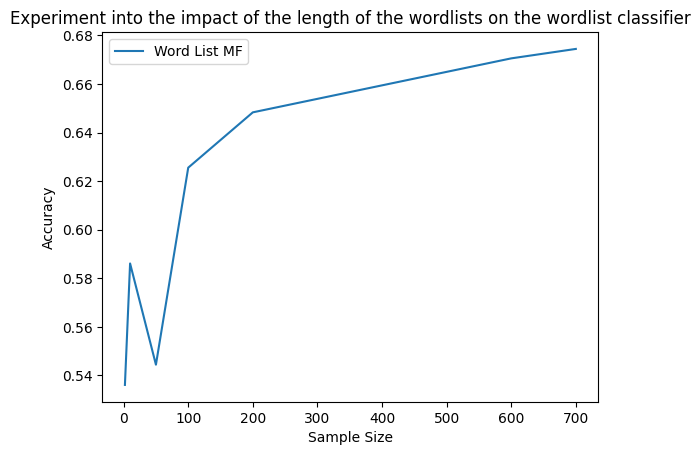

In [15]:
#Graph for accuracy
ax = df.plot(kind="line",title="Experiment into the impact of the length of the wordlists on the wordlist classifier")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")


Text(0.5, 0, 'Sample Size')

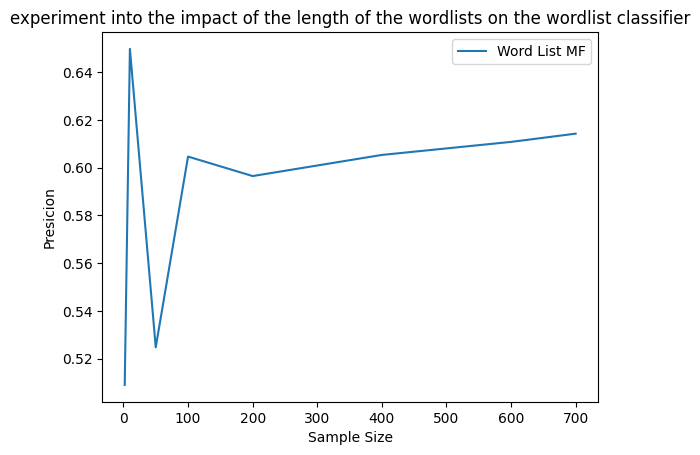

In [16]:
#Graph for precision
ax = precision_graph.plot(kind="line",title="experiment into the impact of the length of the wordlists on the wordlist classifier")
ax.set_ylabel("Presicion")
ax.set_xlabel("Sample Size")

Text(0.5, 0, 'Sample Size')

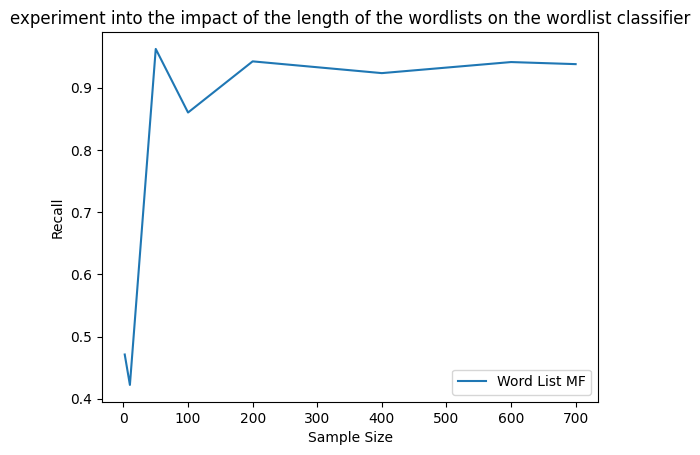

In [17]:
#Graph for recall
ax = recall_graph.plot(kind="line",title="experiment into the impact of the length of the wordlists on the wordlist classifier")
ax.set_ylabel("Recall")
ax.set_xlabel("Sample Size")

Text(0.5, 0, 'Sample Size')

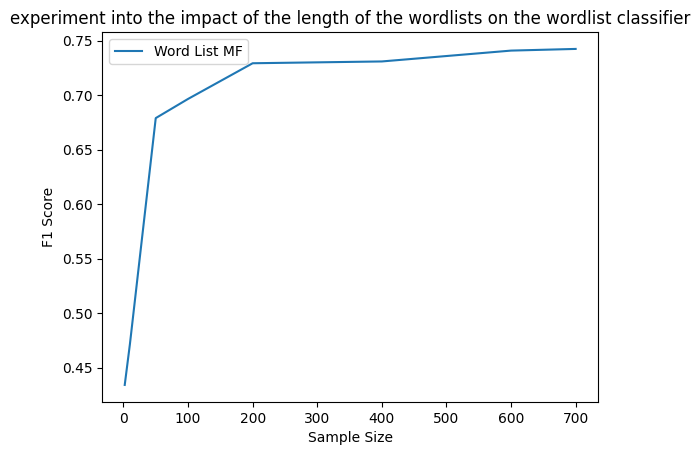

In [18]:
#Graph for F1 Score
ax = f1_graph.plot(kind="line",title="experiment into the impact of the length of the wordlists on the wordlist classifier")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Sample Size")

The choice between the word list and the Naive Bayes classifier I would recommend the Naive Bayes and the reason for that I will explain below.

First of all, word list classifier has its own advantages and disadvantages. The advantages is its interpretability and simplicity, meaning it is quite transparent, easy to interpret and straightforward when trying to implement. However, the disadvantages are that relies on predetermined list of words and is can find challenging ambiguity in instances.

Naives Bayes however advantages outweigh the disadvantages. Firstly, it can capture more complex relationships and makes them more flexible it is quite adaptable and as well as that its much more efficient. The main disadvantage is that its quite sensitive to outliers or rare events in the training data

In conclusion, considering the two classifiers and their observed performances and ability to handle more comlex relationships, I would recommend the Naive Bayes for future work in test classification.